# This notebook contains the code for reproducing results for the following aims:


*   Aim 2: Neglect outcome random forest models
*   Aim 3: Socioeconomic and race association tests with different neglect dimensions



# Install

In [2]:
# !pip install shap
# !pip install lime
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=9d20ce030ce6dcf9075b6901320a38da4690a441a44bfd322546284c8b86e967
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


# Import Libraries



Import some libraries

In [25]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import io

# Utilities

Thesea are mostly helper functions to do miscellaneous data wrangling more easily. Run this whole block, since some of the functions are used later

In [26]:
# missing values per column function
def show_missing_values(df):
    missing_counts = df.isnull().sum()
    missing_percentages = 100 * missing_counts / len(df)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Values', ascending=False)
    return missing_table

In [27]:
def find_no_missing_cols(df):
    no_missing_cols = df.columns[df.isnull().sum() == 0]
    return no_missing_cols

In [28]:
def get_string_columns(df):
    string_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: any([i.isalpha() for i in str(x)])).any():
            string_cols.append(col)
    return string_cols

In [29]:
def convert_sex_to_binary(df, column_name):
    # create a new column with binary values
    df['binary_sex'] = df[column_name].apply(lambda x: 1 if x == 'M' else 0)
    return df

def convert_binary_to_sex(df, column_name):
    # create a new column with 'M' or 'F' values
    df['sex_from_binary'] = df[column_name].apply(lambda x: 'M' if x == 1 else 'F')
    return df

In [30]:
# get rid of nan and all that undefined behavior
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=False)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(float)

In [31]:
def select_all_except_first_row(df):
    return df.iloc[1:]

In [32]:
# missing values per row
def count_nan_rows(df):
    total_rows = len(df)
    nan_rows = df.isnull().any(axis=1).sum()
    nan_percent = 100 * (nan_rows / total_rows)
    print("Number of rows with NaN values: {}".format(nan_rows))
    print("Percentage of rows with NaN values: {:.2f}%".format(nan_percent))
    return nan_rows, nan_percent

In [33]:
def show_missing_rows(df):
    missing_counts = df.isnull().sum(axis=1)
    missing_percentages = 100 * missing_counts / len(df.columns)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Columns'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Columns', ascending=False)
    return missing_table

In [34]:
def count_value(df, value):
    count = (df == value).sum()
    count_table = pd.DataFrame({'Column': count.index, 'Count': count.values}).sort_values('Count', ascending=False)
    return count_table

In [35]:
def remove_rows_with_value(df, value):
    new_df = df[~(df == value).any(axis=1)]
    return new_df

In [36]:
def get_value_counts(df):
  # get unique values and counts for each column
  for column in df.columns:
      counts = df[column].value_counts()
      print(f"Counts for column '{column}':\n{counts}\n")

In [37]:
def compute_stats_ed(df, col1, col2, col3):
    df['Avg Ed'] = df.apply(lambda x: (x[col1] + x[col2])/2 if x[col3] == 1 else x[col1], axis=1)
    df['Max Ed'] = df.apply(lambda x: max(x[col1], x[col2]) if x[col3] == 1 else x[col1], axis=1)
    df['Sum Ed'] = df.apply(lambda x: x[col1] if x[col3] != 1 else x[col1] + x[col2], axis=1)
    return df

In [38]:
def check_number_in_columns(df, columns, number):
    for col in columns:
        if number in df[col].values:
            return True
    return False

In [39]:
def sum_columns(df, column_list, new_column_name):
    df[new_column_name] = df[column_list].sum(axis=1)
    return df

In [40]:
def distplots(df, bins=100):
  for i in range(1,len(df.columns)) :
      col_name = df.columns[i]  # get the column name to identify the graph
      x=df[col_name]
      plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
      k=plt.hist(x,bins)       # Change the right number of bins to get it more/less granular
      plt.show()

In [41]:
def select_columns(df, condition_col, condition_func, cols_to_select):
    """
    Selects a list of columns from a Pandas dataframe based on whether a condition is satisfied in one of the columns.
    """
    # Filter the dataframe to only include rows where the condition is satisfied
    filtered_df = df[df[condition_col].apply(condition_func)]

    # Select the desired columns from the filtered dataframe
    selected_df = filtered_df[cols_to_select]

    return selected_df

In [42]:
def check_value(df, value_cols, no_value_cols, value, new_col_name):
    # Check if value is present only in the specified value_cols
    mask_value = (df[value_cols] == value).all(axis=1)

    # Check if value is not present in any of the specified no_value_cols
    mask_no_value = (df[no_value_cols] != value).all(axis=1)

    # Create a new column with a 1 if both conditions are met, 0 otherwise
    df[new_col_name] = 0
    df.loc[mask_value & mask_no_value, new_col_name] = 1

    return df

In [43]:
def convert_str_to_num(df):
    """
    Converts string representations of numbers in a dataframe to float data type.
    """
    for col in df.columns:
        if df[col].dtypes == object:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # if the column can't be converted, ignore it
    return df

In [44]:
def convert_columns_to_float(df):
    """
    Converts all columns of a Pandas dataframe to be of type float, except for ones that contain alphabetic characters.
    """
    # Get a boolean mask indicating which columns contain alphabetic characters
    non_numeric_cols = df.select_dtypes(include=['object']).apply(lambda col: pd.to_numeric(col, errors='coerce').isna()).any()

    # Select only the numeric columns
    numeric_cols = df.select_dtypes(include=['float', 'int'])

    # Convert the numeric columns to float
    numeric_cols = numeric_cols.apply(pd.to_numeric, errors='coerce').astype('float')

    # Merge the numeric and non-numeric columns
    converted_df = pd.concat([numeric_cols, df.loc[:, non_numeric_cols]], axis=1)

    return converted_df

In [45]:
def column_description_dict(df):
    # Get the first row of the dataframe
    first_row = df.iloc[0]

    # Create a dictionary with column names as keys and first row values as descriptions
    column_descriptions = {col: first_row[col] for col in df.columns}

    return column_descriptions

In [46]:
def my_recode(x):
    if x == 1:
        return 1
    else:
        return 0

# Load dataframe

Raw csv from github is downloaded into a pandas dataframe

In [47]:
# Downloading the csv file from GitHub
url = "https://raw.githubusercontent.com/joshbenjamin3/251/main/Neglect%20outcomes.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

In [48]:
aim1_df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [49]:
aim1_df = aim1_df.drop('Unnamed: 0', axis=1)

In [50]:
aim1_df

,subjectkey,Household Size,Partner Status,Max Ed,INR,Employment Status,INR Group,Highest Education Level,Employment Category,Relationship Status,...,Physical neglect score,Emotional neglect score,Supervisory neglect score,Physical neglect,Emotional neglect,Supervisory neglect,Overall Neglect,Adult Psychopathology,Abuse,Parent psychopathology
0,NDAR_INV01NAYMZH,12.0,1,18.0,2.584425,0,mid income,College,Not working,Partnered,...,0.0,0,0,0,0,0,None,14.0,0,0
1,NDAR_INV028WCTG6,3.0,0,14.0,0.122429,0,deep poverty,High school,Not working,Single,...,1.0,0,0,1,0,0,P,0.0,0,0
2,NDAR_INV00BD7VDC,4.0,1,20.0,8.130081,1,high income,Advanced degree,Part-time,Partnered,...,0.0,0,0,0,0,0,None,10.0,0,0
3,NDAR_INV02H7G2T6,4.0,1,19.0,6.097561,1,high income,Advanced degree,Part-time,Partnered,...,0.0,0,0,0,0,0,None,2.0,0,0
4,NDAR_INV030X9ZNH,5.0,1,19.0,3.040306,2,mid income,Advanced degree,Full-time,Partnered,...,0.0,0,1,0,0,0,None,15.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,NDAR_INVZ8JVVCW2,3.0,0,19.0,3.060725,1,mid income,Advanced degree,Part-time,Single,...,0.0,0,0,0,0,0,None,55.0,0,0
9491,NDAR_INVZJFZNNPJ,4.0,0,16.0,1.727642,2,near poverty,Some college,Full-time,Single,...,0.0,0,0,0,0,0,None,2.0,0,0
9492,NDAR_INVZJJMNJ88,4.0,1,15.0,0.386179,1,deep poverty,Some college,Part-time,Partnered,...,1.0,0,0,1,0,0,P,24.0,0,0
9493,NDAR_INVZV4EUGNG,4.0,1,12.0,0.386179,2,deep poverty,Some high school,Full-time,Partnered,...,1.0,0,0,1,0,0,P,59.0,0,1


# Model ready dataframe

DataFrame is convereted to numpy array format for being input into models

## Aim 2 and 3

In [51]:
X_1 = aim1_df[['Household Size', 'Partner Status', 'Max Ed', 'INR',
       'Employment Status', 'ADI', 'COI',
       'Race grouping', 'Sex', 'Parent psychopathology', 'Abuse']]

X_1_og = aim1_df[['Household Size', 'Partner Status', 'Max Ed', 'INR',
       'Employment Status', 'ADI', 'COI',
       'Race grouping', 'Sex', 'Adult Psychopathology', 'Abuse']]

y_p = aim1_df[['Physical neglect']]

y_e = aim1_df[['Emotional neglect']]

y_s = aim1_df[['Supervisory neglect']]

In [52]:
convert_sex_to_binary(X_1, 'Sex')

<ipython-input-29-3de380f54f7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binary_sex'] = df[column_name].apply(lambda x: 1 if x == 'M' else 0)


,Household Size,Partner Status,Max Ed,INR,Employment Status,ADI,COI,Race grouping,Sex,Parent psychopathology,Abuse,binary_sex
0,12.0,1,18.0,2.584425,0,27.0,77.0,white,M,0,0,1
1,3.0,0,14.0,0.122429,0,51.0,30.0,black,M,0,0,1
2,4.0,1,20.0,8.130081,1,45.0,98.0,white,M,0,0,1
3,4.0,1,19.0,6.097561,1,24.0,87.0,white,F,0,0,0
4,5.0,1,19.0,3.040306,2,48.0,45.0,white,F,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9490,3.0,0,19.0,3.060725,1,24.0,87.0,other,F,0,0,0
9491,4.0,0,16.0,1.727642,2,100.0,1.0,black,M,0,0,1
9492,4.0,1,15.0,0.386179,1,98.0,7.0,other,F,0,0,0
9493,4.0,1,12.0,0.386179,2,40.0,32.0,hispanic,M,1,0,1


In [53]:
X_1 = X_1.drop('Sex', axis=1)

In [54]:
# Convert "Race grouping" column into one-hot vectors
one_hot_df = pd.get_dummies(X_1['Race grouping'], prefix='', prefix_sep='')

# Concatenate the original DataFrame and the one-hot vectors
X_1 = pd.concat([X_1, one_hot_df], axis=1)

In [55]:
aim1_0_df = pd.concat([aim1_df, one_hot_df], axis=1)

In [56]:
X_1 = X_1.drop('Race grouping', axis=1)

In [57]:
show_missing_values(X_1)

,Missing Values,% of Total Values


In [58]:
X_1

,Household Size,Partner Status,Max Ed,INR,Employment Status,ADI,COI,Parent psychopathology,Abuse,binary_sex,black,hispanic,other,white
0,12.0,1,18.0,2.584425,0,27.0,77.0,0,0,1,0,0,0,1
1,3.0,0,14.0,0.122429,0,51.0,30.0,0,0,1,1,0,0,0
2,4.0,1,20.0,8.130081,1,45.0,98.0,0,0,1,0,0,0,1
3,4.0,1,19.0,6.097561,1,24.0,87.0,0,0,0,0,0,0,1
4,5.0,1,19.0,3.040306,2,48.0,45.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,3.0,0,19.0,3.060725,1,24.0,87.0,0,0,0,0,0,1,0
9491,4.0,0,16.0,1.727642,2,100.0,1.0,0,0,1,1,0,0,0
9492,4.0,1,15.0,0.386179,1,98.0,7.0,0,0,0,0,0,1,0
9493,4.0,1,12.0,0.386179,2,40.0,32.0,1,0,1,0,1,0,0


In [59]:
X_1.reset_index(drop=True, inplace=True)
y_p.reset_index(drop=True, inplace=True)
y_e.reset_index(drop=True, inplace=True)
y_s.reset_index(drop=True, inplace=True)

In [60]:
X_1.columns

Index(['Household Size', 'Partner Status', 'Max Ed', 'INR',
       'Employment Status', 'ADI', 'COI', 'Parent psychopathology', 'Abuse',
       'binary_sex', 'black', 'hispanic', 'other', 'white'],
      dtype='object')

# Random forest models

## ML model and analysis dependencies

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

In [62]:
# import shap
import eli5
from eli5.sklearn import PermutationImportance

In [63]:
import itertools

## Model functions

In [71]:
def run_single_model(X, y, cv, scoring):
    # Create a pipeline
    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))])

    scores = []
    for _ in range(cv.get_n_splits(X, y)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        score = {metric: score_func(y_test, y_pred) for metric, score_func in scoring.items()}
        scores.append(score)

        model = pipe.named_steps['classifier']

    return scores, pipe, model


# Scoring dictionary
scoring = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted'),
    'confusion_matrix': lambda y_true, y_pred: confusion_matrix(y_true, y_pred),
    'roc_curve': lambda y_true, y_pred: roc_curve(y_true, y_pred),
    'precision_recall_curve': lambda y_true, y_pred: precision_recall_curve(y_true, y_pred)
}

In [86]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


def run_traditional_cv(X, y, cv, scoring):
    # Create a pipeline with preprocessing and classifier
    pipe = Pipeline([
        ('preprocessing', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))
    ])

    # Prepare scoring dictionary compatible with cross_validate
    compatible_scoring = {key: make_scorer(value) for key, value in scoring.items() if key in ['accuracy', 'precision', 'recall', 'f1', 'auc']}

    # Perform cross-validation and store the results
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring=compatible_scoring, return_train_score=False)

    # Aggregate the scores for each metric
    aggregated_scores = {metric: sum(scores) / len(scores) for metric, scores in cv_results.items() if metric.startswith('test_')}

    return aggregated_scores, pipe

# Example usage
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=5)
# X, y = # your data here
# scores, trained_pipeline = run_traditional_cv(X, y, cv, scoring)


In [72]:
# Create an instance of StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [73]:
def extract_instances(dataset, num_instances):
    # Check if the number of instances requested is greater than the dataset size
    if num_instances > len(dataset):
        raise ValueError("Number of instances requested is greater than dataset size.")

    # Resample the dataset to extract the desired number of instances
    extracted_instances = resample(dataset, n_samples=num_instances, replace=False)

    return extracted_instances

In [74]:
def calculate_permutation_importance(model, X, y, scoring_metric):
    perm_importance = PermutationImportance(model, scoring=scoring_metric, random_state=42)
    perm_importance.fit(X, y)
    feature_importances = perm_importance.feature_importances_
    feature_names = X.columns

    sorted_indices = np.argsort(feature_importances)
    sorted_importances = feature_importances[sorted_indices][::-1]
    sorted_names = feature_names[sorted_indices][::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_names)
    plt.xlabel('Permutation Importance')
    plt.ylabel('Features')
    plt.title('Permutation Importance of Features')
    plt.show()

In [75]:
# Scoring dictionary 2
scoring2 = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted'),
}

In [76]:
from sklearn.utils import resample

def run_bootstrap_model(X, y, n_iterations, scoring):
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessing', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))
    ])

    bootstrap_scores = {metric: [] for metric in scoring}

    for _ in range(n_iterations):
        # Bootstrap sampling
        X_sample, y_sample = resample(X, y, replace=True, n_samples=len(y), random_state=_)

        # Split the bootstrap sample
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)

        # Train the model and make predictions
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # Calculate and store the scores for each metric
        for metric, score_func in scoring.items():
            score = score_func(y_test, y_pred)
            bootstrap_scores[metric].append(score)

    # Calculate confidence intervals for each metric
    confidence_intervals = {}
    for metric, scores in bootstrap_scores.items():
        lower = np.percentile(scores, 2.5)
        upper = np.percentile(scores, 97.5)
        confidence_intervals[metric] = (lower, upper)

    return confidence_intervals

In [110]:
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def bootstrap_cross_validation(X, y, n_bootstrap, cv, scoring_functions):
    # Convert scoring functions to scorer objects
    scoring = {metric: make_scorer(func) for metric, func in scoring_functions.items() if metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']}

    # Initialize results dictionary
    results = {metric: [] for metric in scoring}

    for i in range(n_bootstrap):
        # Create a bootstrap sample
        X_sample, y_sample = resample(X, y)

        # Create a pipeline with preprocessing and classifier
        pipe = Pipeline([
            ('preprocessing', StandardScaler()),
            ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))
        ])

        # Perform cross-validation on the bootstrap sample
        cv_results = cross_validate(pipe, X_sample, y_sample, cv=cv, scoring=scoring, return_train_score=False)

        # Aggregate the scores
        for metric in scoring:
            metric_scores = cv_results['test_' + metric]
            results[metric].append(np.mean(metric_scores))

    # Calculate final aggregate scores and confidence intervals
    final_scores = {metric: {"mean": np.mean(scores), "95% CI": (np.percentile(scores, 2.5), np.percentile(scores, 97.5))}
                    for metric, scores in results.items()}

    return final_scores

# Example usage
scoring_functions = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted')
}

# Number of bootstrap samples
n_bootstrap = 25

# Number of splits
cv = StratifiedKFold(n_splits=10)

In [82]:

# n_iterations = 1000

## Plotting functions

In [78]:
def plot_evaluation(pipe, X, y):
    # Calculate and display evaluation metrics
    y_pred = pipe.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Confusion Matrix
    im = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_title('Confusion Matrix')

    # Add numbers to the confusion matrix cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0, 0].text(j, i, cm[i, j], ha='center', va='center', color='black')

    # Colorbar for the confusion matrix
    cbar = axes[0, 0].figure.colorbar(im, ax=axes[0, 0])
    cbar.ax.set_ylabel('Counts', rotation=90, va='bottom')

    # ROC Curve
    axes[0, 1].plot(fpr, tpr)
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')

    # Precision-Recall Curve
    axes[1, 0].plot(recall, precision)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')

    # Feature Importances
    importances = pipe.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Reverse order

    axes[1, 1].barh(range(len(indices)), importances[indices], color='b', align='center')
    axes[1, 1].set_yticks(range(len(indices)))
    axes[1, 1].set_yticklabels([X.columns[i] for i in indices])
    axes[1, 1].set_xlabel('Relative Importance')
    axes[1, 1].set_title('Feature Importances')
    axes[1, 1].invert_yaxis()

    # # Display evaluation metrics
    # table_data = [['Accuracy', accuracy],
    #               ['Precision', precision],
    #               ['Recall', recall],
    #               ['F1-Score', f1],
    #               ['AUC', auc]]

    # # Select the top value for each metric
    # table_data = [[metric, score] for metric, score in table_data]

    # table = axes[1, 0].table(cellText=table_data, colWidths=[0.3, 0.2], loc='center')
    # table.auto_set_font_size(False)
    # table.set_fontsize(10)

    # Adjust plot layout
    plt.tight_layout()
    plt.show()

In [79]:
def generate_metrics_table(scores):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metrics_table = pd.DataFrame(columns=['Metric', 'Score'])

    for metric in metrics:
        scores_for_metric = [score[metric] for score in scores]
        max_score = np.max(scores_for_metric)

        metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)

    return metrics_table

In [90]:
def generate_metrics_table2(aggregated_scores):
    metrics_table = pd.DataFrame(columns=['Metric', 'Score'])

    for metric, score in aggregated_scores.items():
        # Add each metric and its aggregated score to the table
        metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': score}, ignore_index=True)

    return metrics_table

In [80]:
def plot_confidence_intervals(confidence_intervals):
    # Prepare data for plotting
    metrics = list(confidence_intervals.keys())
    lower_bounds = [ci[0] for ci in confidence_intervals.values()]
    upper_bounds = [ci[1] for ci in confidence_intervals.values()]
    means = [(lower + upper) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]
    errors = [(upper - lower) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
    plt.ylabel('Score')
    plt.title('95% Confidence Intervals for Model Metrics')
    plt.ylim(0, 1)  # Set y-axis limit to be from 0 to 1 as these are typical bounds for the metrics

    # Add the actual interval values as text labels
    for bar, lower, upper in zip(bars, lower_bounds, upper_bounds):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + errors[0] + 0.02, f'[{lower:.4f}, {upper:.4f}]', ha='center')

    # Show the plot
    plt.show()

In [108]:
def plot_bootstrap_cv_results(final_scores):
    # Prepare data for plotting
    metrics = list(final_scores.keys())
    means = [score_info["mean"] for score_info in final_scores.values()]
    lower_bounds = [score_info["95% CI"][0] for score_info in final_scores.values()]
    upper_bounds = [score_info["95% CI"][1] for score_info in final_scores.values()]
    errors = [(upper - lower) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
    plt.ylabel('Score')
    plt.title('Mean Scores with 95% Confidence Intervals')
    plt.ylim(0, 1)  # Set y-axis limit to be from 0 to 1 as these are typical bounds for the metrics

    # Add the actual interval values as text labels
    for bar, mean, lower, upper in zip(bars, means, lower_bounds, upper_bounds):
        plt.text(bar.get_x() + bar.get_width() / 2, mean + errors[0] + 0.02, f'{mean:.4f}\n[{lower:.4f}, {upper:.4f}]', ha='center', fontsize=8)

    # Show the plot
    plt.show()

In [114]:
def create_results_table(final_scores):
    # Create a DataFrame from the final scores
    data = {
        'Metric': [],
        'Mean Score': [],
        '95% Confidence Interval': []
    }

    for metric, stats in final_scores.items():
        data['Metric'].append(metric)
        data['Mean Score'].append(round(stats['mean'], 4))  # Round the mean for better readability
        # Format the confidence interval
        ci_formatted = f"[{round(stats['95% CI'][0], 4)}, {round(stats['95% CI'][1], 4)}]"
        data['95% Confidence Interval'].append(ci_formatted)

    results_table = pd.DataFrame(data)
    return results_table

## Association tests (aim 3)

This contains the functions and computations of the $\chi^2$ analyis

In [ ]:
def create_contingency_table(df, variable1, variable2):
    # Select the columns of interest from the DataFrame
    subset = df[[variable1, variable2]]

    # Create the contingency table using pandas crosstab
    contingency_table = pd.crosstab(subset[variable1], subset[variable2])

    return contingency_table

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
def calculate_chi2_test(df, variable1, variable2):
    # Create the contingency table using pandas crosstab
    contingency_table = pd.crosstab(df[variable1], df[variable2])

    # Perform G-test
    g, p, _, expected = chi2_contingency(contingency_table)

    # lambda_="log-likelihood"
    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Chi2 test statistic': [g],
        'p-value': [p]
    })

    return results_df

### Race and neglect type

In [ ]:
aim1_df[["INR Group"]]

,INR Group
0,mid income
1,deep poverty
2,high income
3,high income
4,mid income
...,...
9490,mid income
9491,near poverty
9492,deep poverty
9493,deep poverty


In [ ]:
get_value_counts(aim1_df[['Race']])

Counts for column 'Race':
White                                           5282
Black                                           1214
White/Hispanic                                  1014
Other Race/Hispanic                              315
White/Black                                      282
                                                ... 
Japanese/Other Race                                1
White/American Indian/Alaska Native/Hispanic       1
White/Asian Indian/Hispanic                        1
White/Black/American Indian/Korean                 1
White/Chinese/Other Asian                          1
Name: Race, Length: 172, dtype: int64



In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['Physical neglect'])

Physical neglect,0,1
Race grouping,,
black,852,362
hispanic,1387,400
other,1011,201
white,4800,482


In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['Emotional neglect'])

Emotional neglect,0,1
Race grouping,,
black,1175,39
hispanic,1757,30
other,1188,24
white,5193,89


In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['Supervisory neglect'])

Supervisory neglect,0,1
Race grouping,,
black,1134,80
hispanic,1698,89
other,1152,60
white,5105,177


In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['INR Group'])

INR Group,deep poverty,high income,mid income,near poverty,poverty
Race grouping,,,,,
black,321,152,247,307,187
hispanic,231,420,485,390,261
other,101,593,252,197,69
white,107,3033,1415,561,166


In [ ]:
pd.crosstab(aim1_df['Physical neglect'], aim1_df['INR Group'])

INR Group,deep poverty,high income,mid income,near poverty,poverty
Physical neglect,,,,,
0,439,4105,2073,1024,409
1,321,93,326,431,274


In [ ]:
pd.crosstab(aim1_0_df['Physical neglect'], aim1_0_df['white'])

white,0,1
Physical neglect,,
0,3250,4800
1,963,482


In [ ]:
pd.crosstab(aim1_0_df['Physical neglect'], aim1_0_df['black'])

black,0,1
Physical neglect,,
0,7198,852
1,1083,362


In [ ]:
calculate_chi2_test(aim1_df, 'INR Group', 'Physical neglect')

,Chi2 test statistic,p-value
0,1547.177464,0.0


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'Physical neglect')

,Chi2 test statistic,p-value
0,425.420967,6.892513e-92


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'Emotional neglect')

,Chi2 test statistic,p-value
0,12.915371,0.004823


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,30.433555,0.000001


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'INR Group')

,Chi2 test statistic,p-value
0,2077.314078,0.0


In [ ]:
calculate_chi2_test(aim1_0_df, 'black', 'Physical neglect')

,Chi2 test statistic,p-value
0,228.677625,1.158068e-51


In [ ]:
calculate_chi2_test(aim1_0_df, 'white', 'Physical neglect')

,Chi2 test statistic,p-value
0,341.4831,3.033052e-76


In [ ]:
calculate_chi2_test(aim1_0_df, 'hispanic', 'Physical neglect')

,Chi2 test statistic,p-value
0,86.912084,1.134540e-20


In [ ]:
calculate_chi2_test(aim1_0_df, 'other', 'Physical neglect')

,Chi2 test statistic,p-value
0,1.888659,0.169353


In [ ]:
calculate_chi2_test(aim1_0_df, 'black', 'Emotional neglect')

,Chi2 test statistic,p-value
0,11.652689,0.000641


In [ ]:
calculate_chi2_test(aim1_0_df, 'white', 'Emotional neglect')

,Chi2 test statistic,p-value
0,3.130843,0.076824


In [ ]:
calculate_chi2_test(aim1_0_df, 'hispanic', 'Emotional neglect')

,Chi2 test statistic,p-value
0,0.516485,0.472345


In [ ]:
calculate_chi2_test(aim1_0_df, 'other', 'Emotional neglect')

,Chi2 test statistic,p-value
0,0.003624,0.951995


In [ ]:
calculate_chi2_test(aim1_0_df, 'black', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,17.565055,0.000028


In [ ]:
calculate_chi2_test(aim1_0_df, 'white', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,24.374368,7.931702e-07


In [ ]:
calculate_chi2_test(aim1_0_df, 'hispanic', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,2.461278,0.116684


In [ ]:
calculate_chi2_test(aim1_0_df, 'other', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,1.361398,0.243295


## Neglect outcomes (aim 2)

Models grouped by outcome along with scoring metrics, and feature importances

### Physical Neglect

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

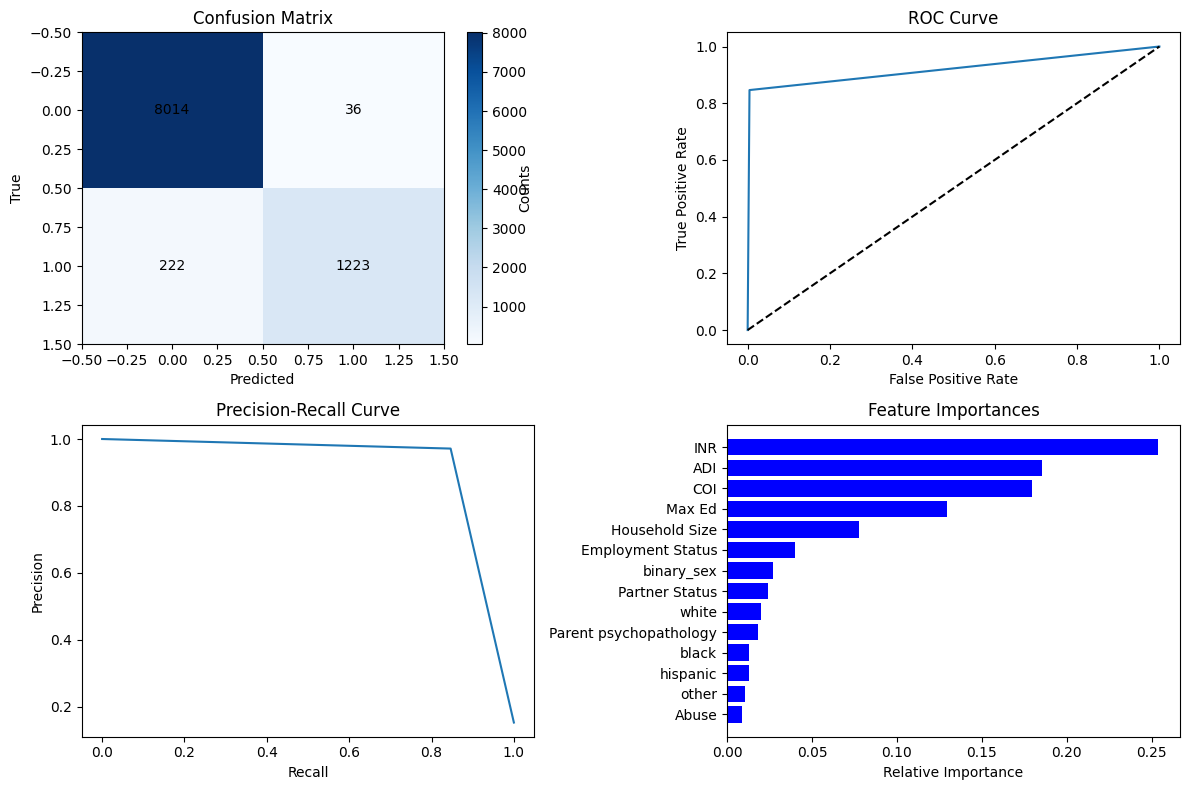

<ipython-input-79-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)
<ipython-input-79-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)
<ipython-input-79-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)
<ipython-input-79-f0a6cc8a2dd0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

,Metric,Score
0,Accuracy,0.865719
1,Precision,0.845157
2,Recall,0.865719
3,F1,0.836820
4,Auc,0.605669


In [84]:
# Run single model
scores_p, pipe_p, model_p = run_single_model(X_1, y_p, strat_k_fold, scoring)

plot_evaluation(pipe_p, X_1, y_p)

generate_metrics_table(scores_p)

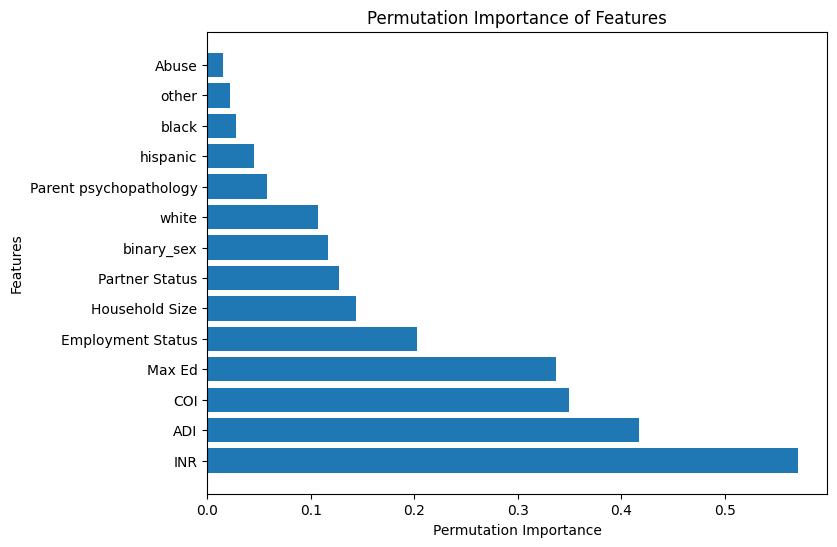

In [85]:
calculate_permutation_importance(pipe_p, X_1, y_p, 'f1')

### Emotional Neglect

In [ ]:
# Run single model
scores_e, pipe_e, model_e = run_single_model(X_1, y_e, strat_k_fold, scoring)

plot_evaluation(pipe_e, X_1, y_e)

generate_metrics_table(scores_e)

In [ ]:
calculate_permutation_importance(pipe_e, X_1, y_e, 'f1')

### Supervisory Neglect

In [ ]:
# Run single model
scores_s, pipe_s, model_s = run_single_model(X_1, y_s, strat_k_fold, scoring)

plot_evaluation(pipe_s, X_1, y_s)

generate_metrics_table(scores_s)

In [ ]:
calculate_permutation_importance(pipe_s, X_1, y_s, 'f1')

# Bootstrap confidence intervals

## Physical neglect

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

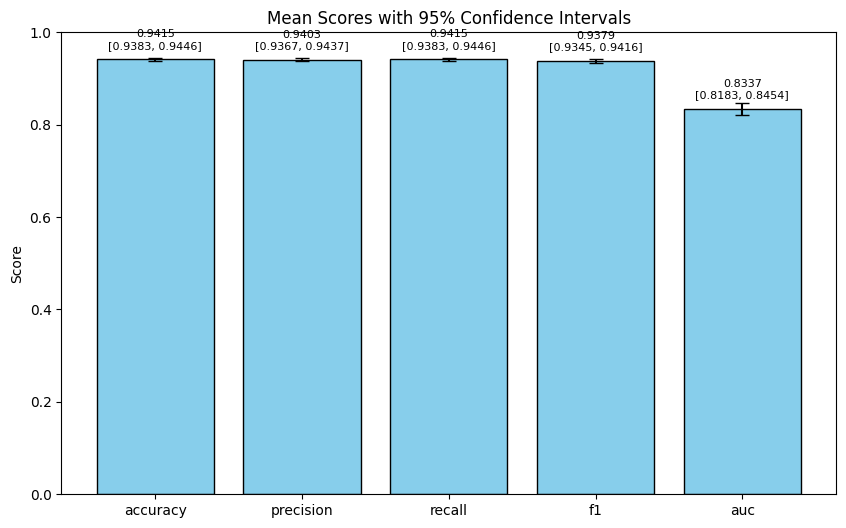

CPU times: user 3min 36s, sys: 681 ms, total: 3min 36s
Wall time: 3min 35s


In [111]:
%%time

ci_p = bootstrap_cross_validation(X_1, y_p, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_p)

In [115]:
create_results_table(ci_p)

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.9415,"[0.9383, 0.9446]"
1,precision,0.9403,"[0.9367, 0.9437]"
2,recall,0.9415,"[0.9383, 0.9446]"
3,f1,0.9379,"[0.9345, 0.9416]"
4,auc,0.8337,"[0.8183, 0.8454]"


## Emotional neglect

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

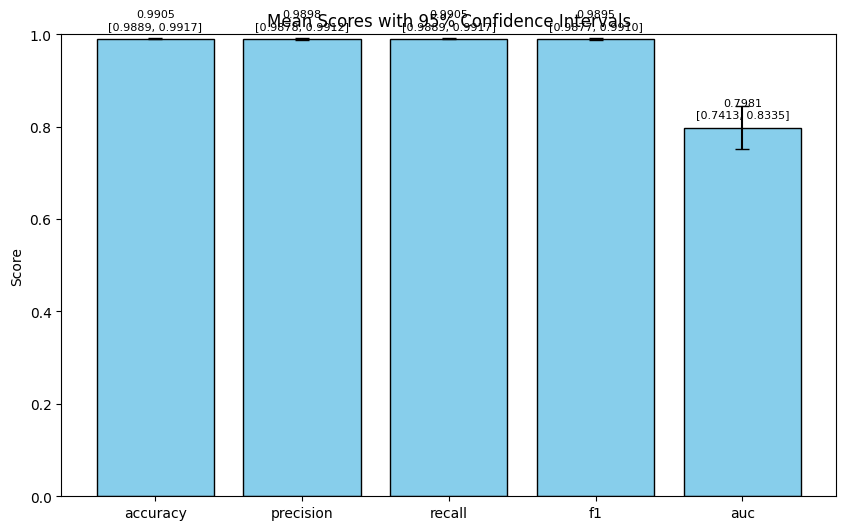

In [112]:
ci_e = bootstrap_cross_validation(X_1, y_e, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_e)

In [116]:
create_results_table(ci_e)

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.9905,"[0.9889, 0.9917]"
1,precision,0.9898,"[0.9878, 0.9912]"
2,recall,0.9905,"[0.9889, 0.9917]"
3,f1,0.9895,"[0.9877, 0.991]"
4,auc,0.7981,"[0.7413, 0.8335]"


## Supervisory neglect

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

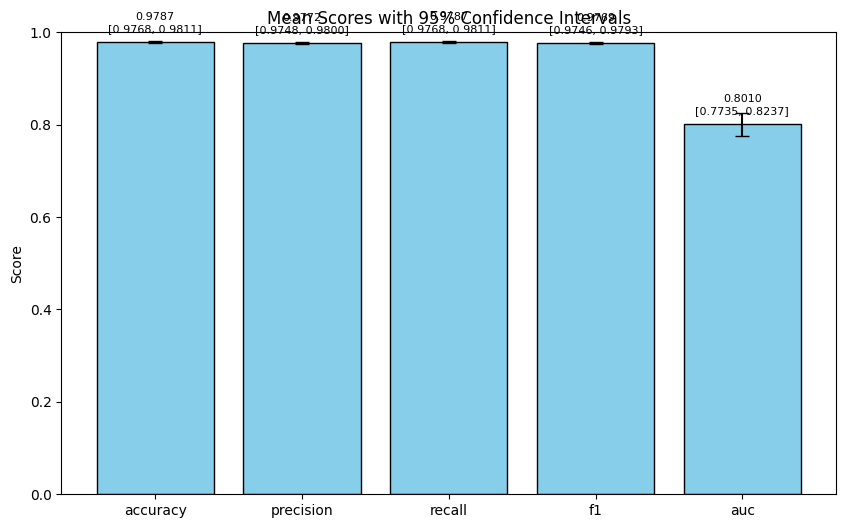

In [113]:
ci_s = bootstrap_cross_validation(X_1, y_s, n_bootstrap, cv, scoring_functions)

plot_bootstrap_cv_results(ci_s)

In [117]:
create_results_table(ci_s)

,Metric,Mean Score,95% Confidence Interval
0,accuracy,0.9787,"[0.9768, 0.9811]"
1,precision,0.9772,"[0.9748, 0.98]"
2,recall,0.9787,"[0.9768, 0.9811]"
3,f1,0.9769,"[0.9746, 0.9793]"
4,auc,0.8010,"[0.7735, 0.8237]"
